In [ ]:
!pip install IPython
from IPython.display import Image

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git # colab 사용시

In [ ]:
# Image('image/image_1.JPG') # 로컬 사용시
Image('/content/LG_time_series_day02_dataset/image/image_1.JPG') # colab 사용시

# [Recurrent Neural Networks - 분류] 

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

### 1. 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

import time
import copy

import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt     
import itertools

import warnings
warnings.filterwarnings(action='ignore') 

### 2. 데이터 불러오기

In [ ]:
'''
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# co2_data = pd.read_csv('data/co2.csv')
# co2_data = pd.read_csv('/content/LG_time_series_day02_dataset/data/co2.csv')
train = pd.read_csv('./data/cls_train.csv')
test = pd.read_csv('./data/cls_test.csv')

#### 2.1 Data Exploratory Data Analysis

In [ ]:
train.head() # 상위 5개

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [ ]:
train.tail() # 하위 5개

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,30,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,30,WALKING_UPSTAIRS
7351,0.351503,-0.012423,-0.203867,-0.269270,-0.087212,0.177404,-0.377404,-0.038678,0.229430,0.269013,...,-0.740738,-0.280088,-0.007739,-0.056088,-0.616956,-0.783267,0.246809,0.036695,30,WALKING_UPSTAIRS


In [ ]:
train.shape # 데이터 차원 확인

(7352, 563)

In [ ]:
train.describe() # 데이터 통계값 확인

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [ ]:
train['Activity'].value_counts() # 데이터 클래스 정보 확인

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [ ]:
x_train = train.drop(['subject', 'Activity'], axis=1)
x_test = test.drop(['subject', 'Activity'], axis=1)
y_train = train['Activity']
y_test = test['Activity']

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (7352, 561)
y_train shape is (7352,)
x_test shape is (2947, 561)
y_test shape is (2947,)


In [ ]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
print(pd.Series(y_train).value_counts())

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
dtype: int64


#### 2.2 Data Windowing

In [ ]:
def windowing_process(x, y, window_size, shift_size, last = True):
    x = x.reset_index(drop=True)
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1])
        
        else:
            count_class = Counter(y[start_idx:start_idx + window_size])
            y_window.append(count_class.most_common(n=1)[0][0])
        
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [ ]:
x_train, y_train = windowing_process(x_train, y_train, 10, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 10, 1, True)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (7343, 10, 561)
y_train shape is (7343,)
x_test shape is (2938, 10, 561)
y_test shape is (2938,)


In [ ]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')


x_train shape is (1924, 10, 561)
y_train shape is (1924,)
-----------------------------------
x_train shape is (481, 10, 561)
y_train shape is (481,)
-----------------------------------
x_test shape is (2938, 10, 561)
y_test shape is (2938,)


### 3. RNN Modeling

#### 3.1 Define the Model Structure

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.rnn_type = rnn_type
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # rnn_type에 따른 recurrent layer 설정
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, self.num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # 선택한 rnn_type의 RNN으로부터 output 도출
        if self.rnn_type in ['rnn', 'gru']:
            out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
            # initial cell states 설정
            c0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
            out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :])
        return out

#### 3.2 Define The Training Testing Strategy

In [ ]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, num_classes, device='cuda'):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.input_size = input_size
        self.num_classes = num_classes

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 

        train_loss_history = []        
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_acc = 0.0

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_corrects = 0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device, dtype=torch.long)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                        _, preds = torch.max(outputs, 1) ##### 첫 _에는 원래 실제 max값이 들어감 (여기서는 아마 softmax 중 max 실제값)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    running_total += labels.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                epoch_acc = running_corrects.double() / running_total

                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)


        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():
            corrects = 0
            total = 0
            preds = []
            probs = []
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)

                # forward
                # input을 model에 넣어 output을 도출
                outputs = model(inputs)
                prob = outputs
                prob = nn.Softmax(dim=1)(prob)
                
                # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                _, pred = torch.max(outputs, 1)
                
                # batch별 정답 개수를 축적함
                corrects += torch.sum(pred == labels.data)
                total += labels.size(0)

                preds.extend(pred.detach().cpu().numpy())
                probs.extend(prob.detach().cpu().numpy())

            preds = np.array(preds)
            probs = np.array(probs)
            acc = (corrects.double() / total).item()
       
        return preds, probs, acc

### 4. Model Training

#### 4.1 Hyperparameter Setting

In [ ]:
batch_size = 128
input_size = x_train.shape[2]
num_classes = len(np.unique(y_train))
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='rnn'
best_model_path = f'./ckpt/{rnn_type}_cls.pt'

#### 4.2 Construct Data Loaders and Model

In [ ]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
model =  RNN_model(input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type, device)
model = model.to(device)

#### 4.3 Model Training and Save Weights(Parameters)

In [ ]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, num_classes, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/200
train Loss: 1.6695 Acc: 0.3113
val Loss: 1.5663 Acc: 0.4220

Epoch 10/200
train Loss: 0.7150 Acc: 0.9132
val Loss: 0.7994 Acc: 0.7672

Epoch 20/200
train Loss: 0.2856 Acc: 0.9563
val Loss: 0.4950 Acc: 0.8337

Epoch 30/200
train Loss: 0.1411 Acc: 0.9777
val Loss: 0.4882 Acc: 0.8108

Epoch 40/200
train Loss: 0.0787 Acc: 0.9917
val Loss: 0.4549 Acc: 0.8212

Epoch 50/200
train Loss: 0.0528 Acc: 0.9948
val Loss: 0.3743 Acc: 0.8482

Epoch 60/200
train Loss: 0.0368 Acc: 0.9958
val Loss: 0.3734 Acc: 0.8545

Epoch 70/200
train Loss: 0.0279 Acc: 0.9974
val Loss: 0.4751 Acc: 0.8337

Epoch 80/200
train Loss: 0.0205 Acc: 0.9984
val Loss: 0.4611 Acc: 0.8503

Epoch 90/200
train Loss: 0.0164 Acc: 0.9990
val Loss: 0.2133 Acc: 0.9106

Epoch 100/200
train Loss: 0.0130 Acc: 0.9979
val Loss: 0.3155 Acc: 0.8690

Epoch 110/200
train Loss: 0.0101 Acc: 0.9995
val Loss: 0.3882 Acc: 0.8607

Epoch 120/200
train Loss: 0.0177 Acc: 0.9969
val Loss: 0.3560 Acc: 0.8524

Epoch 130/200
train Loss: 0.0065 Ac

In [ ]:
torch.save(best_model.state_dict(), best_model_path)

### 5. Model Validation

#### 5.1 Loss History Visualization

Text(0, 0.5, 'loss')

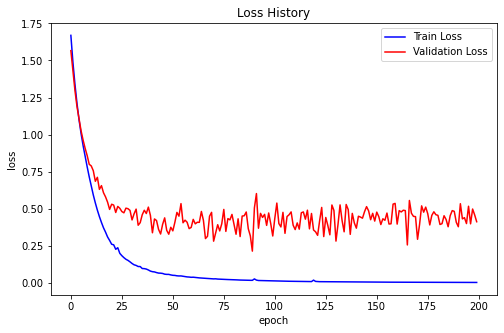

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Loss History')
plt.plot(range(num_epochs), train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

#### 5.2 Load Model Weights(Parameters)

In [ ]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
y_pred, y_prob, acc = trainer.test(model, test_loader)
print(y_pred[0])
print(y_prob[0])

2
[1.6850166e-04 8.6520445e-03 9.9053156e-01 2.1985815e-04 4.7382757e-05
 3.8065491e-04]


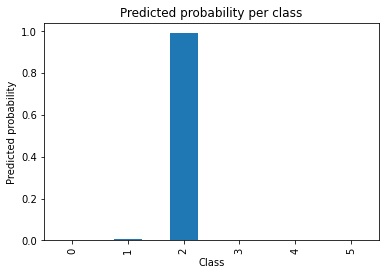

In [ ]:
pd.Series(y_prob[0]).plot(kind='bar')
plt.title('Predicted probability per class')
plt.xlabel('Class')
plt.ylabel('Predicted probability')
plt.show()

In [ ]:
cr = pd.DataFrame(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_), output_dict=True))
print(cr)

               LAYING     SITTING    STANDING     WALKING  WALKING_DOWNSTAIRS  \
precision    1.000000    0.862816    0.951168    0.974828            0.744136   
recall       0.979516    0.973523    0.856597    0.858871            0.830952   
f1-score     0.989652    0.914833    0.901408    0.913183            0.785152   
support    537.000000  491.000000  523.000000  496.000000          420.000000   

           WALKING_UPSTAIRS  accuracy    macro avg  weighted avg  
precision          0.866944  0.899932     0.899982      0.906224  
recall             0.885350  0.899932     0.897468      0.899932  
f1-score           0.876050  0.899932     0.896713      0.901084  
support          471.000000  0.899932  2938.000000   2938.000000  


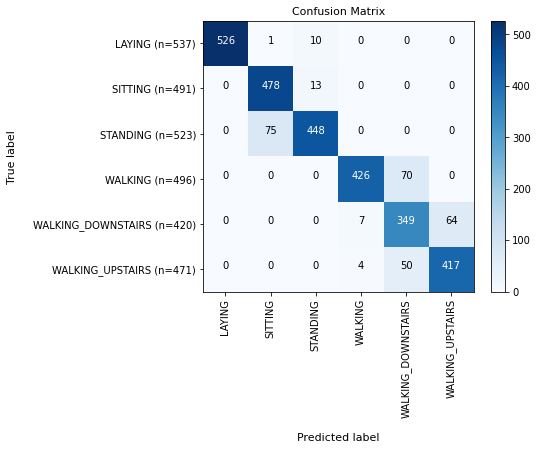

In [ ]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.figure(figsize=(8,6))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=11)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0} (n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels, fontsize=10)
    plt.xticks(rotation=90)
    plt.yticks(marks, nlabels, fontsize=10)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label\n', fontsize=11)
    plt.xlabel('\nPredicted label', fontsize=11)
    plt.show()
    
plot_confusion_matrix(cm, labels=list(label_encoder.classes_), normalize=False)

# EOD